# Implementing Singular Value Decomposition algorithm with application to Linear Regression analysis

Routines in this implemetation are based on discussions given in [1], which are themselves based on algorithm by Golub and Kahan ([2]) and its implementation presented in [3] by Golub and Reinsch.  

This implemention is still in development, since I aim to make it free of any external package dependancy. Numpy and matplotlib have been used only for matrix multiplication and plotting. More features would be added to this implemention to make it more robust.

Essentially, this algorithm first reduces the matrix to an upper-bidiagonal matrix by application of **Householder reduction**. Then upper-bidiagonal matrix is reduced to a diagonal matrix by iterative application of **QR decomposition**. Diagonals of the matrix so obtained are singular values of the matrix.  

SVD so obtained is further used to calculate pseudo-inverse in the Linear Regression analysis. 


**_References_**

[1] Stewart, Gilbert W. Matrix Algorithms: Volume II: Eigensystems. Society for Industrial and Applied Mathematics, 2001.

[2] Golub, Gene, and William Kahan. "Calculating the singular values and pseudo-inverse of a matrix." Journal of the Society for Industrial and Applied Mathematics, Series B: Numerical Analysis 2.2 (1965): 205-224.

[3] Golub, Gene H., and Christian Reinsch. "Singular value decomposition and least squares solutions." Numerische mathematik 14.5 (1970): 403-420.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt                                

In [2]:
%matplotlib inline

In [4]:
def housegen(a):
    u=a
    v=np.linalg.norm(a)
    if v==0:
        u[0]=np.sqrt(2)
        return u,v
    elif(u[0]!=0):
        rho=u[0]/abs(u[0])
    else:
        rho=1

    u=np.multiply((rho/v),u)
    u[0]=1+u[0]
    u=u/np.sqrt(u[0])
    v=-rho*v
    return u,v    

In [5]:
def BiReduce(X,m,n):
    d=np.matrix(np.zeros((1,n)))
    e=np.matrix(np.zeros((1,n)))
    for k in range(0,n):
        if(k<n):
            a,d[0,k]=housegen(X[k:m,k])
            X[k:m,k]=a
            b=a.T*X[k:m,k+1:n]
            X[k:m,k+1:n]=X[k:m,k+1:n]-a*b
        
        if(k<n-2):
            b,e[0,k]=housegen(X[k,k+1:n].T)
            X[k,k+1:n]=b.T
            a=X[k+1:m,k+1:n]*b
            X[k+1:m,k+1:n]=X[k+1:m,k+1:n]-a*b.T
    e[0,n-2]=X[n-2,n-1]
    U=np.matrix(np.diag(np.ones(m)))
    for k in range(min(n-1,m-1),-1,-1):
        a=X[k:,k]
        b=a.T*U[k:m,k:n]
        U[k:m,k:n]=U[k:m,k:n]-a*b
    
    V=np.matrix(np.diag(np.ones(n)))
    for k in range(n-3,-1,-1):
        b=X[k,k+1:n].T
        a=b.T*V[k+1:n,k+1:n]
        V[k+1:n,k+1:n]=V[k+1:n,k+1:n]-b*a
    return e,d,U,V

In [6]:
def rotgen(a,b):
    if(b==0):
        c=1
        s=0
        return c,s
    if(a==0):
        c=0
        s=1
        a=b
        b=0
        return c,s
    u=a/abs(a)
    tau=abs(a)+abs(b)
    eta=tau*(np.sqrt((a/tau)*(a/tau)+(b/tau)*(b/tau)))
    c=abs(a)/eta
    s=u*(b/eta)
    a=eta*u
    b=0
    return c,s

In [7]:
def rotapp(c,s,x,y):
    t=c*x+s*y
    y=c*y-s*x
    x=t
    return x,y

In [8]:
def BiQR(d,e,sigma,i1,i2,U,V):
    scl=max(d[0,i1],e[0,i1],sigma)
    dl=d[0,i1]/scl
    el=e[0,i1]/scl
    sig=sigma/scl
    f=(dl+sig)*(dl-sig)
    g=dl*el
    for k in range(i1,i2):
        c,s=rotgen(f,g)
        if k!=i1:
            e[0,k-1]=f
        f=c*d[0,k]+s*e[0,k]
        e[0,k]=c*e[0,k]-s*d[0,k]
        g=s*d[0,k+1]
        d[0,k+1]=c*d[0,k+1]
        V[:,k],V[:,k+1]=rotapp(c,s,V[:,k],V[:,k+1])
        c,s=rotgen(f,g)
        d[0,k]=f
        f=c*e[0,k]+s*d[0,k+1]
        d[0,k+1]=c*d[0,k+1]-s*e[0,k]
        if k<i2-1:
            g=s*e[0,k+1]
            e[0,k+1]=c*e[0,k+1]
        U[:,k],U[:,k+1]=rotapp(c,s,U[:,k],U[:,k+1])
    e[0,i2-2]=f 
    return d,e,U,V

In [9]:
def BdBackSearch(d,e,tol,l):
    i2=l
    i1=l
    while i1>0:
        if(i1==i2):
            tau=d[0,i1]
        elif(e[0,i1-1]!=0):
            tau=d[0,i1]*(tau/(tau+abs(e[0,i1-1])))
        
        if abs(e[0,i1-1])<=tol*tau:
            e[0,i1-1]=0
            if(i1==i2):
                i1=i1-1
                i2=i1-1
            else:
                return
        else:
            i1=i1-1
    return i1,i2 

In [10]:
def lm(X,Y,m,n,its):
    X1=np.matrix(X)
    e,d,U,V=BiReduce(X1,m,n)
    p=d[0,n-2]
    r=e[0,n-1]
    q=d[0,n-1]
    sigma_max=(np.sqrt((p+q)*(p+q)+r*r)+np.sqrt((p-q)*(p-q)+r*r))/2
    sigma_min=abs(p*q)/sigma_max
    i1,i2=BdBackSearch(d,e,0.0000000001,1)

    for k in range(0,its):
        d,e,U,V=BiQR(d,e,sigma_min,i1,i2,U,V)
    SIG=np.matrix(np.vstack([np.diag([d[0,0],d[0,1]]),np.zeros((m-n,2))]))
    for k in range(0,2):
        if SIG[k,k]!=0:
            SIG[k,k]=1/SIG[k,k]
    x=V*SIG.T*U.T*Y
    
    return x

In [79]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = [
    ]
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data.append(x)
    return data


init_means = [
    [5, 0.9], # mean of cluster 1
]
init_covariances = [
    [[.5, .1], [.1, .1]], # covariance of cluster 1
]
init_weights = [1]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)
data=np.array(data)
X=np.hstack([np.matrix(np.ones(len(data[:,0]))).T,np.matrix(np.power(data[:,0],1)).T])
Y=np.matrix(data[:,1]).T

In [68]:
x1= np.as_array(X[:,1])

AttributeError: module 'numpy' has no attribute 'as_array'

In [77]:
np.array(Y).flatten()

array([-0.06276753,  0.35214822, -0.3324741 , -0.36390736,  0.04815989,
       -0.12652275,  0.08437836,  0.28673963, -0.78634671,  0.1780655 ,
        0.47585599, -0.58070159, -0.05487721, -0.64230148, -0.49396256,
        0.26018025, -0.37211731,  0.23749057, -0.18961552, -0.62596775,
        0.23487779,  0.3915972 ,  0.25510147, -0.20819587,  0.61028945,
        0.50898546,  0.33613891, -0.12707307, -0.20366713,  0.04031294,
       -0.6479263 , -0.32113604,  0.17639741, -0.01796607, -0.18508884,
        0.05231808,  0.19389855, -0.09543085,  0.48215199,  0.16307904,
       -0.25366754, -0.34985746,  0.06648977, -0.27361708, -0.23187789,
        0.16409576,  0.11238853, -0.11353813, -0.2529722 ,  0.17839586,
       -0.07199892, -0.1553261 ,  0.03039918,  0.18808987, -0.06242348,
        0.35512716, -0.27475452, -0.21568636, -0.08210631,  0.3074785 ,
        0.00138975, -0.4674647 , -0.10511706, -0.07646123,  0.21287607,
       -0.41664116, -0.22830739,  0.00568764, -0.07119528, -0.75

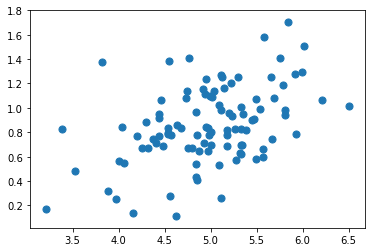

In [80]:
plt.scatter(np.array(x1).flatten(), np.array(Y).flatten(),s=50)

In [65]:
coeff=lm(X,Y,100,2,10)

In [82]:
from scipy import linalg

In [91]:
coeff = linalg.inv(X.T*X)*(X.T*Y)

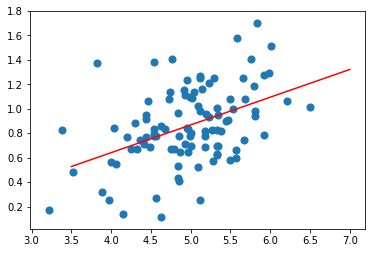

In [92]:
#Linear Regression
xx = np.linspace(3.5, 7, 20)
yy = np.array(coeff[0] + coeff[1]* np.power(xx,1) )
plt.plot(xx, yy.T, color='r')
plt.scatter(np.array(x1).flatten(), np.array(Y).flatten(),s=50)
plt.show()